<a href="https://colab.research.google.com/github/KolKemboi/Generative-Model/blob/main/emoji_gan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import matplotlib
from keras.datasets import mnist

from IPython import display

In [2]:
(train_data, train_labels), (_, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype("float32")
train_data = (train_data - 127.5) / 127.5

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## THE GENERATOR MODEL

In [6]:
from keras import layers

In [7]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = "same", use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 28, 28, 1)

    return model



In [8]:
generator = generator()

In [9]:
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training = False)

In [10]:
import matplotlib.pyplot as plt

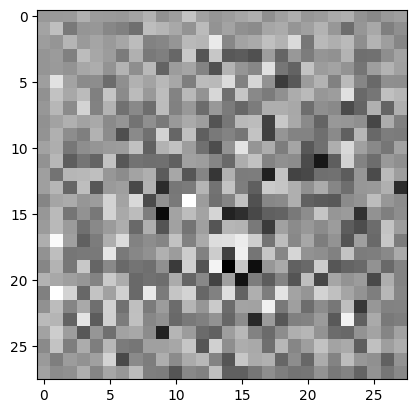

In [11]:
plt.imshow(gen_img[0, :, :, 0], cmap ="gray")

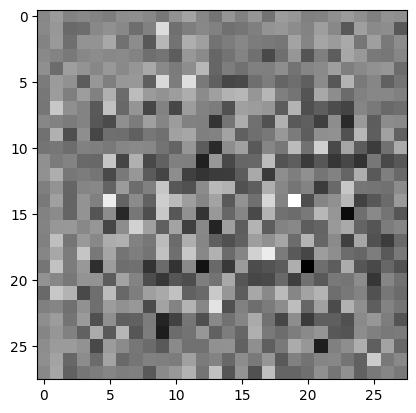

In [12]:
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training = False)
plt.imshow(gen_img[0, :, :, 0], cmap ="gray")

## THE DISCRIMATOR

In [13]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = "same", input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = "same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = discriminator()
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[0.00024191]], shape=(1, 1), dtype=float32)


## LOSS FUNCTION

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

## checkpoints

In [19]:
import os
checkpoints_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")

In [20]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator
)

In [21]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 10

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    grad_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gen_of_disc, discriminator.trainable_variables))

In [23]:
import time
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1,
                                seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time()-start}")

    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (4, 4))


    for i in range(predictions.shape[0]):
        plt.subplot(4, 4,  i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = "gray")
        plt.axis("off")

    plt.savefig(f"image_at_epoch {epoch : 04d}")
    plt.show()

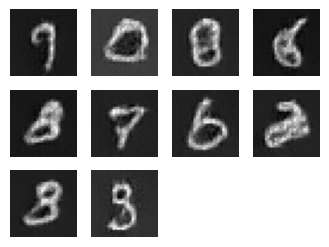

In [25]:
train(train_dataset, EPOCHS)